In [91]:
#from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
#from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import pandas as pd

sr = 44100

# gan에 입력되는 noise에 대한 dimension
NOISE_DIM = 10 #잘 모르겠음...ㅎㅎ

# adam optimizer 정의, learning_rate = 0.0002, beta_1로 줍니다.
# Vanilla Gan과 DCGAN에서 이렇게 셋팅을 해주는데
# 이렇게 해줘야 훨씬 학습을 잘합니다.
# 그렇다고 합니다..ㅎㅎ
adam = Adam(lr=0.0002, beta_1=0.5)
mfcc_data = []

In [74]:
def load_wave_generator(path): #이전 깃헙에서 가져온 파일 읽어들이는 함수(라벨 붙이는것만 삭제)

    batch_waves = []
    stft_data = []
    fft_data = []
    temp = []
    global s_data, f_data

    folders = os.listdir(path)

    for folder in folders:
        if not os.path.isdir(path):continue #폴더가 아니면 continue
        files = os.listdir(path+"/"+folder)
        print("Foldername :",folder,"-",len(files),"files")
        #폴더 이름과 그 폴더에 속하는 파일 갯수 출력
        for wav in files:
            if not wav.endswith(".wav"):continue
            else:
                print("Filename :",wav)#.wav 파일이 아니면 continue
                y, sr = librosa.load(path+"/"+folder+"/"+wav)
                ny = y[:sr*5]
                stft = librosa.stft(ny,)
                stft = np.abs(stft)
                
                fft = np.fft.fft(ny)
                fft = fft[:int(len(magnitude)/2)]
                
                fft_data.append(fft)
                stft_data.append(stft)
                print("Stft Size : ", stft.shape)
                print("fft Size : ", fft.shape)
                
    #end loop
    #print("X_data :",np.shape(X_data))
    s_data = stft_data
    f_data = fft_data
    

load_wave_generator("./data")    #일단 RYU 음성 읽어오기
stft_data = np.array(s_data)
fft_data = np.array(f_data)
#print(np.shape(sound_data))
print(stft_data.shape)
fft_data.shape

Foldername : 1 - 20 files
Filename : Ryu1.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu10.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu11.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu12.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu13.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu14.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu15.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu16.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu17.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu18.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu19.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu2.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu20.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu3.wav
Stft Size :  (1025, 216)
fft Size :  (68352,)
Filename : Ryu4.wav
Stft Size :  (1025,

(20, 68352)

In [87]:
print(stft_data.shape)
fft_data.shape

(20, 1025, 216)


(20, 68352)

In [92]:
"""
generator = Sequential([                 #generator 시퀀스 생성 
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(1025, activation='tanh'),
])
"""
generator = Sequential()
generator.add(Conv2D(512, input_dim=NOISE_DIM, activation='relu'))
generator.add(Conv2D(256, padding='same', activation='relu'))
generator.add(Conv2D(1024, activation='relu'))
generator.add()

In [76]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               2816      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1025)             

In [77]:
discriminator = Sequential([
    Dense(1024, input_shape=(1025,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), #relu의 개선버전
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

In [78]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              1050624   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)              

In [79]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [80]:
# discriminator는 학습을 하지 않도록 하며, Gan 모델에서는 generator만 학습하도록 합니다.
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

In [81]:
gan = Model(gan_input, output)
gan.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1025)              1710337   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1707009   
Total params: 3,417,346
Trainable params: 1,710,337
Non-trainable params: 1,707,009
_________________________________________________________________


In [83]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [84]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    #오디오 파일 듣기 추가 요망

In [85]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

In [86]:
BATCH_SIZE = 128
EPOCHS= 50

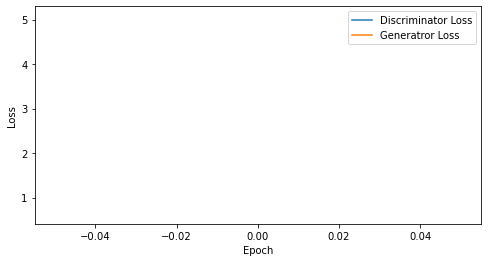

epoch: 1, Discriminator Loss: 5.074507713317871, Generator Loss: 0.6347533464431763


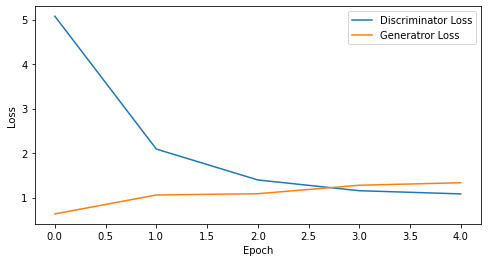

epoch: 5, Discriminator Loss: 2.1608264684677123, Generator Loss: 1.079432201385498


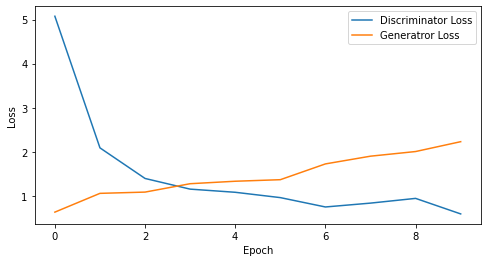

epoch: 10, Discriminator Loss: 1.4898807883262635, Generator Loss: 1.4637097716331482


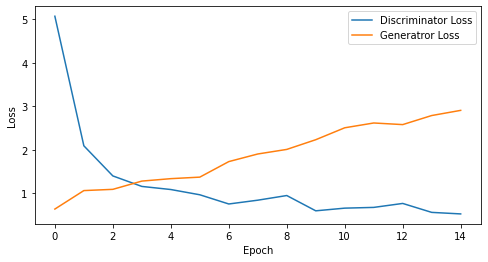

epoch: 15, Discriminator Loss: 1.2048566142717998, Generator Loss: 1.8689841826756795


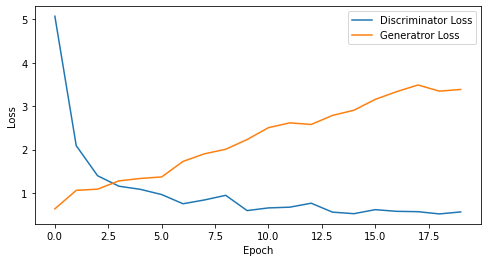

epoch: 20, Discriminator Loss: 1.045744353532791, Generator Loss: 2.23760204911232


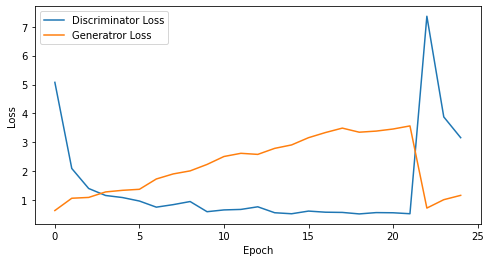

epoch: 25, Discriminator Loss: 1.4558358478546143, Generator Loss: 2.1866719913482666


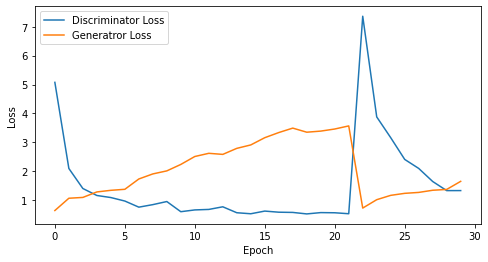

epoch: 30, Discriminator Loss: 1.5061684489250182, Generator Loss: 2.0502397656440734


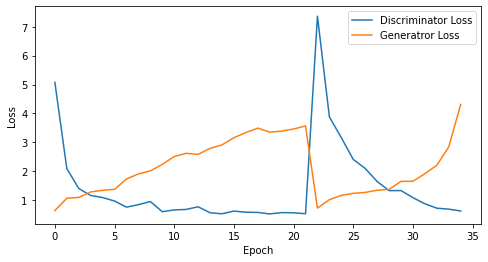

epoch: 35, Discriminator Loss: 1.4043374879019601, Generator Loss: 2.126125986235482


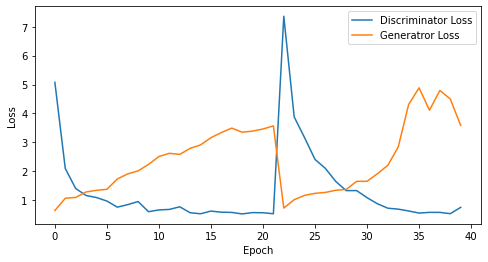

epoch: 40, Discriminator Loss: 1.3027596920728683, Generator Loss: 2.4071505635976793


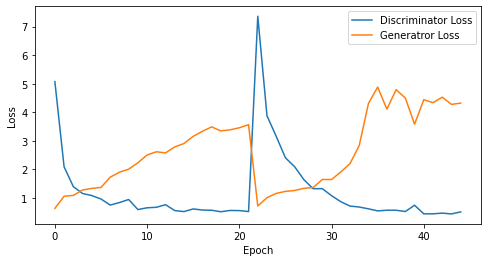

epoch: 45, Discriminator Loss: 1.2093436492813958, Generator Loss: 2.6265286948945787


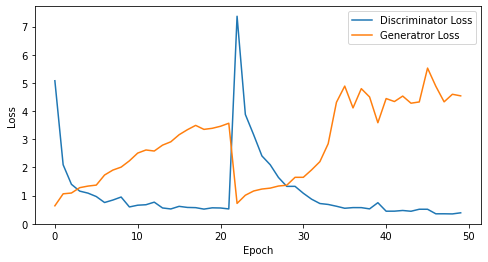

epoch: 50, Discriminator Loss: 1.127342361807823, Generator Loss: 2.8410664439201354


In [48]:
# discriminator와 gan 모델의 loss 측정을 위한 list 입니다.
d_losses = []
g_losses = []
gen_rst = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_sounds in get_batches(X_train, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        generated_sounds = generator.predict(input_noise)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_sounds, generated_sounds])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지합니다
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if(epoch==50):
        gen_rst=np.array(generated_sounds)
    
    #gen_rst.append(librosa.feature.inverse.mfcc_to_audio())
    
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)
        
gan.save('GAN-s_tft_v1.h5')

In [49]:
gen_mfcc = []
gen_rst = np.array(gen_rst)
print(gen_rst[0][0])
gen_rst = gen_rst.reshape(128,500,45)
for i in range(128):
    gen_mfcc.append(gen_rst[i].T)
gen_mfcc = np.array(gen_mfcc)
gen_mfcc.shape

-0.99900764


(128, 45, 500)

In [50]:
test = librosa.feature.inverse.mfcc_to_audio(gen_mfcc[127])
test.shape

(255488,)

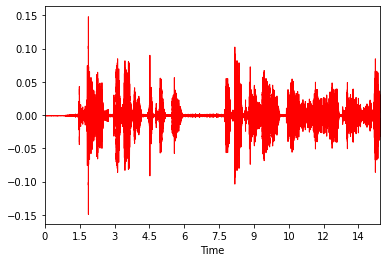

In [16]:
import librosa.display
librosa.display.waveplot(test, sr=sr, color='r')

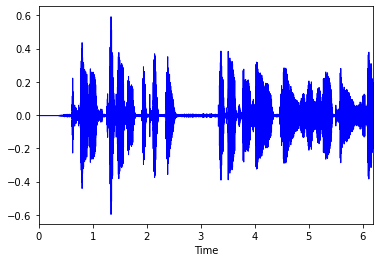

In [26]:
y, sr = librosa.load("./test.wav")
fft = np.fft.fft(y)
#test = librosa.feature.inverse.mfcc_to_audio(mfcc_test)
import soundfile as sf
sf.write('output1.wav', test, sr, subtype='PCM_24')
librosa.display.waveplot(y, sr=sr, color='b')

(136704,)


Text(0.5, 1.0, 'Power spectrum')

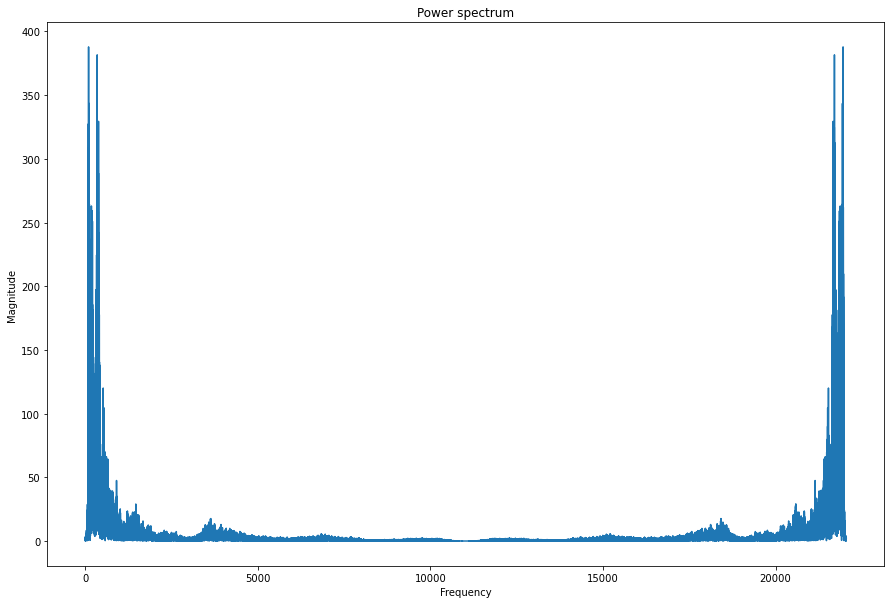

In [32]:
magnitude = np.abs(fft)
print(magnitude.shape)
f = np.linspace(0, sr, len(magnitude))

left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]

FIG_SIZE = (15,10)
plt.figure(figsize=FIG_SIZE)
plt.plot(f, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")